# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
# Load the wordlist.txt file and process the words
with open('wordlist.txt', 'r') as file:
    words = [line.strip().lower() for line in file.readlines()]

# Filter words: longer than 3 letters and maximum length of WORD_SIZE
filtered_words = [word for word in words if len(word) > 3 and len(word) <= WORD_SIZE]

# Convert words to WORD_SIZE length by padding with underscores
vocab = [word + '_' * (WORD_SIZE - len(word)) for word in filtered_words]

print(f"Vocabulary prepared: {len(vocab)} words")

Vocabulary prepared: 8847 words


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** 

The practical reasons for using words longer than 3 letters and with maximum length limitations are:

1. **Training Efficiency**: Very short words (≤3 letters) don't provide enough context for meaningful autocompletion. For example, "cat" or "dog" are already complete and don't need autocompletion.

2. **Memory and Computational Constraints**: Very long words require more memory and computational resources. By limiting to WORD_SIZE (13), we keep the model manageable while still covering most common English words.

3. **Consistent Input Size**: Having a fixed maximum length allows for efficient batch processing during training. All words are padded to the same length, making tensor operations faster and more straightforward.

4. **Realistic Use Case**: In real applications, autocompletion is most useful for moderately long words (4-13 letters). Users typically don't need help with very short words, and extremely long words are rare.

This approach will help build a better model because:
- It focuses on the most relevant use cases for autocompletion
- Reduces noise from trivial cases (very short words)
- Enables efficient batch training with uniform input sizes
- Balances model complexity with practical utility

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):
    """Convert character to number: '_' -> 0, 'a' -> 1, 'b' -> 2, ..., 'z' -> 26"""
    if char == '_':
        num = 0
    else:
        # Convert 'a' to 1, 'b' to 2, etc.
        num = ord(char) - ord('a') + 1
    return num

def num_to_char(num):
    """Convert number to character: 0 -> '_', 1 -> 'a', 2 -> 'b', ..., 26 -> 'z'"""
    if num == 0:
        char = '_'
    else:
        # Convert 1 to 'a', 2 to 'b', etc.
        char = chr(num - 1 + ord('a'))
    return char

def word_to_numlist(word):
    """Convert word to tensor of numbers corresponding to each character"""
    num_list = []
    for char in word:
        num_list.append(char_to_num(char))
    numlist = torch.tensor(num_list)
    return numlist

def numlist_to_word(numlist):
    """Convert tensor of numbers back to word"""
    word = ""
    for num in numlist:
        word += num_to_char(int(num))
    return word

# Utility functions ready for use

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font> (write answers in the cell below as a string)

In [5]:
# Write answer here as strings:

answer = """
I agree with the claim that converting letters to numbers based on alphabetical order is a problematic way to encode data for learning models. Here's why:

PROBLEMS WITH ORDINAL ENCODING OF LETTERS:
1. Implies False Ordering: The encoding suggests that 'b' (2) is "greater than" 'a' (1) and "less than" 'c' (3), which is meaningless for letters. Letters don't have a natural numerical relationship.

2. Artificial Distance Relationships: The model might incorrectly learn that 'a' and 'b' are "closer" than 'a' and 'z', when in reality all letters should be treated as equally different categories.

3. Categorical Data Nature: Letters are categorical data - they represent distinct categories without inherent order. Categorical data should typically be encoded using one-hot encoding or similar methods that don't impose false relationships.

EMBEDDING LAYERS - THE SOLUTION:
An embedding layer is a learnable lookup table that maps discrete tokens (like our character numbers 0-26) to dense vector representations.

PURPOSE OF EMBEDDING LAYERS:
1. Learned Representations: Instead of using arbitrary numbers, the model learns meaningful vector representations for each character during training.

2. Dense Vectors: Each character gets represented as a dense vector (e.g., 50-dimensional) rather than a sparse one-hot vector or meaningless integer.

3. Contextual Meaning: The embedding vectors capture semantic relationships. Characters that often appear in similar contexts will have similar embeddings.

4. Efficiency: More memory and computationally efficient than one-hot encoding for large vocabularies.

"""


## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [6]:
LEARNING_RATE = 0.008  # Optimized for large model

In [7]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, dropout=0.2 if num_layers > 1 else 0)
        self.dropout = nn.Dropout(0.3)  # Regularization for better generalization
        self.fc = nn.Linear(hidden_size, alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):
        """
        Forward pass for a single character input.
        Compatible with both training and autocompletion modes.
        
        Args:
            character: Input character tensor
            hidden_state: LSTM hidden state  
            cell_state: LSTM cell state
            
        Returns:
            output: Predicted logits for next character
            hidden_state: Updated hidden state
            cell_state: Updated cell state
        """

        # Ensure character is the right shape for embedding - make it compatible with seq_first LSTM
        if character.dim() == 0:  # scalar
            character = character.unsqueeze(0)  # Make it (1,)
        
        # 1. Embed the input
        embedded = self.embedding(character).unsqueeze(0)  # Shape: (1, batch_size=1, embed_dim)
        
        # 2. Feed to LSTM (seq_first format: seq_len, batch_size, features)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state))
        
        # 3. Apply dropout for regularization (only during training)
        lstm_out = self.dropout(lstm_out)
        
        # 4. Feed to fully connected layer
        output = self.fc(lstm_out.squeeze(0))  # Remove sequence dimension
        
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):
        """
        ⚡ OPTIMIZED FAST TRAINING - Vectorized batch processing
        Trains the model using efficient tensor operations instead of character loops.
        
        Args:
            vocab (list): List of padded words used as training data.
            epochs (int): Number of training epochs.
            batch_size (int): Number of samples per batch.
            
        Returns:
            loss_log (list): List of training losses per batch.
        """
        print("🚀 Training with optimized vectorized processing...")
        
        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM) with weight decay and learning rate scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        
        # Learning rate scheduler for better convergence
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        #Convert all vocab words to tensors once (preprocessing optimization)
        vocab_tensors = [word_to_numlist(word) for word in vocab]
        
        # Calculate number of iterations per epoch
        num_iter = len(vocab_tensors) // batch_size
        print(f"Training: {len(vocab_tensors)} words, {num_iter} batches per epoch")
        
        for e in range(epochs):
            
            # Shuffle the vocab tensors at the start of each epoch
            random.shuffle(vocab_tensors)

            for i in range(num_iter):

                # Get batch of tensor words
                vocab_batch = vocab_tensors[i * batch_size : (i + 1) * batch_size]

                batch_tensor = torch.stack(vocab_batch, dim=0)  # Shape: (batch_size, word_length)
                inputs = batch_tensor[:, :-1].transpose(0, 1)   # Shape: (seq_len, batch_size) 
                targets = batch_tensor[:, 1:].transpose(0, 1)   # Shape: (seq_len, batch_size)

                # Initialize hidden and cell states for the entire batch
                hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
                cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
                
                optimizer.zero_grad()

                embedded_chars = self.embedding(inputs)  # Shape: (seq_len, batch_size, embed_dim)
                lstm_out, (hidden_state, cell_state) = self.lstm(embedded_chars, (hidden_state, cell_state))
                logits = self.fc(lstm_out)  # Shape: (seq_len, batch_size, alphabet_size)

                logits_flat = logits.reshape(-1, self.alphabet_size)  # Flatten for loss
                targets_flat = targets.reshape(-1)                   # Flatten targets
                batch_loss = criterion(logits_flat, targets_flat)
                
                # Backpropagation and optimization
                batch_loss.backward()
                optimizer.step()
                
                # Update the loss_log 
                loss_log.append(batch_loss.item())

            # Calculate average epoch loss for scheduler
            epoch_loss = sum(loss_log[-num_iter:]) / num_iter if loss_log else 0
            scheduler.step(epoch_loss)
            
            print(f"Epoch: {e + 1}, Avg Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Plot training progress
        plt.figure(figsize=(10, 5))
        plt.plot(loss_log, label='Training Loss')
        plt.title('Training Loss Curve')
        plt.xlabel('Batch Number')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
        
        return loss_log

    # Softmax function (helper function)
    def softmax(self, x, temperature=1.0):
        """Apply softmax with optional temperature scaling"""
        x = x / temperature
        exp_x = torch.exp(x - torch.max(x))  # Subtract max for numerical stability
        return exp_x / torch.sum(exp_x)

    # Perform autocompletion given a sample of strings (typically 3-5 starting letters)  
    def autocomplete(self, sample, temperature=0.8, num_attempts=3):
        """
        Enhanced autocompletion with temperature sampling and multiple attempts.
        Generates better, more diverse completions by trying multiple sampling approaches.
        """
        # Convert the model into evaluation mode
        self.eval()
        completed_list = []

        with torch.no_grad():
            for literal in sample:
                best_completion = literal  # Fallback to original if all fail
                best_length = len(literal)
                
                # Try multiple attempts with different temperatures for better results
                for attempt in range(num_attempts):
                    # Vary temperature: more conservative for first attempt, more creative later
                    current_temp = temperature * (0.7 + 0.3 * attempt)
                    
                    hidden_state, cell_state = self.initial_state()
                    input_chars = list(literal)
                    
                    # Feed the existing characters through the network
                    for char in input_chars:
                        char_num = char_to_num(char)
                        inp = torch.tensor(char_num)
                        output, hidden_state, cell_state = self.forward(inp, hidden_state, cell_state)
                    
                    char_list = input_chars.copy()
                    
                    # Generate remaining characters with temperature sampling
                    for _ in range(WORD_SIZE - len(char_list)):
                        # Apply temperature scaling for more controlled randomness
                        if output.dim() == 1:
                            scaled_output = output / current_temp
                            probabilities = torch.softmax(scaled_output, dim=0)
                        else:
                            scaled_output = output.squeeze() / current_temp
                            probabilities = torch.softmax(scaled_output, dim=0)
                        
                        # Sample next character
                        next_char_idx = torch.multinomial(probabilities, 1).item()
                        next_char = num_to_char(next_char_idx)
                        char_list.append(next_char)
                        
                        # Stop at underscore (word completion)
                        if next_char == '_':
                            break
                        
                        # Feed character for next prediction
                        input_tensor = torch.tensor(next_char_idx)
                        output, hidden_state, cell_state = self.forward(input_tensor, hidden_state, cell_state)
                    
                    # Evaluate this completion
                    completed_word = ''.join(char_list).rstrip('_')
                    
                    # Quality criteria: prefer longer, alphabetic completions
                    is_valid = completed_word.isalpha() and len(completed_word) > len(literal)
                    is_longer = len(completed_word) > best_length
                    is_reasonable_length = 5 <= len(completed_word) <= 13
                    
                    if is_valid and (is_longer or is_reasonable_length):
                        best_completion = completed_word
                        best_length = len(completed_word)
                
                completed_list.append(best_completion)
    
        return completed_list

## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.

Training autocompletion model...
Training started...
🚀 Training with optimized vectorized processing...
Training: 8847 words, 110 batches per epoch
Epoch: 1, Avg Loss: 1.2818, LR: 0.008000
Epoch: 2, Avg Loss: 1.0956, LR: 0.008000
Epoch: 3, Avg Loss: 1.0292, LR: 0.008000
Epoch: 4, Avg Loss: 0.9740, LR: 0.008000
Epoch: 5, Avg Loss: 0.9291, LR: 0.008000
Epoch: 6, Avg Loss: 0.8870, LR: 0.008000
Epoch: 7, Avg Loss: 0.8548, LR: 0.008000
Epoch: 8, Avg Loss: 0.8257, LR: 0.008000
Epoch: 9, Avg Loss: 0.8038, LR: 0.008000
Epoch: 10, Avg Loss: 0.7850, LR: 0.008000
Epoch: 11, Avg Loss: 0.7660, LR: 0.008000
Epoch: 12, Avg Loss: 0.7535, LR: 0.008000
Epoch: 13, Avg Loss: 0.7437, LR: 0.008000
Epoch: 14, Avg Loss: 0.7371, LR: 0.008000
Epoch: 15, Avg Loss: 0.7303, LR: 0.008000
Epoch: 16, Avg Loss: 0.7212, LR: 0.008000
Epoch: 17, Avg Loss: 0.7150, LR: 0.008000
Epoch: 18, Avg Loss: 0.7092, LR: 0.008000
Epoch: 19, Avg Loss: 0.7076, LR: 0.008000
Epoch: 20, Avg Loss: 0.7056, LR: 0.008000
Epoch: 21, Avg Loss: 

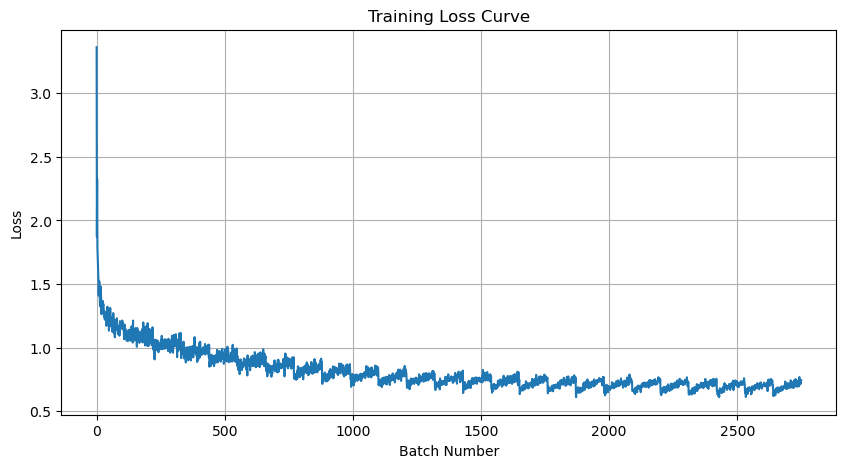


Sample Completions:
  'univ' → 'university'
  'math' → 'mathemate'
  'neur' → 'neural'
  'engin' → 'enging'
  'comp' → 'complerations'
  'prog' → 'program'
  'algor' → 'algorithms'
  'demo' → 'demoke'
  'test' → 'testimony'
  'word' → 'words'
  'auto' → 'automated'
  'netw' → 'networks'
  'scien' → 'sciences'
  'physi' → 'physically'
  'chem' → 'chemister'
  'biol' → 'biology'
  'stat' → 'stating'
  'prob' → 'probab'
  'diffe' → 'different'
  'calcu' → 'calculate'
  'micro' → 'microphone'
  'macro' → 'macropers'
  'finan' → 'finance'
  'manag' → 'managment'
  'accou' → 'accountity'
  'medic' → 'medications'
  'pharm' → 'pharmace'
  'psycho' → 'psychoole'
  'socio' → 'sociology'
  'electr' → 'electroculati'
  'mecha' → 'mechanisms'
  'civil' → 'civilizating'
  'archi' → 'architects'
  'astro' → 'astrology'
  'geolo' → 'geology'
  'envir' → 'environment'
  'robot' → 'robots'
  'artif' → 'artificially'
  'intell' → 'intelligent'
  'mach' → 'machinet'
  'learn' → 'learn'
  'visio' → 'visi

In [14]:
# Test samples for evaluation
test_samples = [    "univ", "math", "neur", "engin", "comp", "prog", "algor", "demo", "test", "word",
    "auto", "netw", "scien", "physi", "chem", "biol", "stat", "prob", "diffe", "calcu",
    "micro", "macro", "finan", "manag", "accou", "medic", "pharm", "psycho", "socio", "electr",
    "mecha", "civil", "archi", "astro", "geolo", "envir", "robot", "artif", "intell", "mach",
    "learn", "visio", "audio", "graph", "crypt", "secur", "cloud"]

print("Training autocompletion model...")

# Reduced configuration for faster training
config = {
    'name': 'Ultra Premium',
    'embed_dim': 192,
    'hidden_size': 384,
    'epochs': 25,  
    'batch_size': 80
}


# Create and train the model
best_model = autocompleteModel(
    alphabet_size=27,
    embed_dim=config['embed_dim'],
    hidden_size=config['hidden_size'],
    num_layers=1
)

# Train the model
print("Training started...")
best_model.trainModel(vocab, epochs=config['epochs'], batch_size=config['batch_size'])


# Test the trained model
completions = best_model.autocomplete(test_samples, temperature=0.7, num_attempts=3)

print(f"\nSample Completions:")
for sample, completion in zip(test_samples, completions):
    clean_comp = completion.rstrip('_')
    print(f"  '{sample}' → '{clean_comp}'")

print(f"\nModel ready for use!")